In [1]:
%load_ext autoreload
%autoreload 2
from data import *
from visualisation2 import *
import numpy as np
from image_processing import *
# from analysis import *

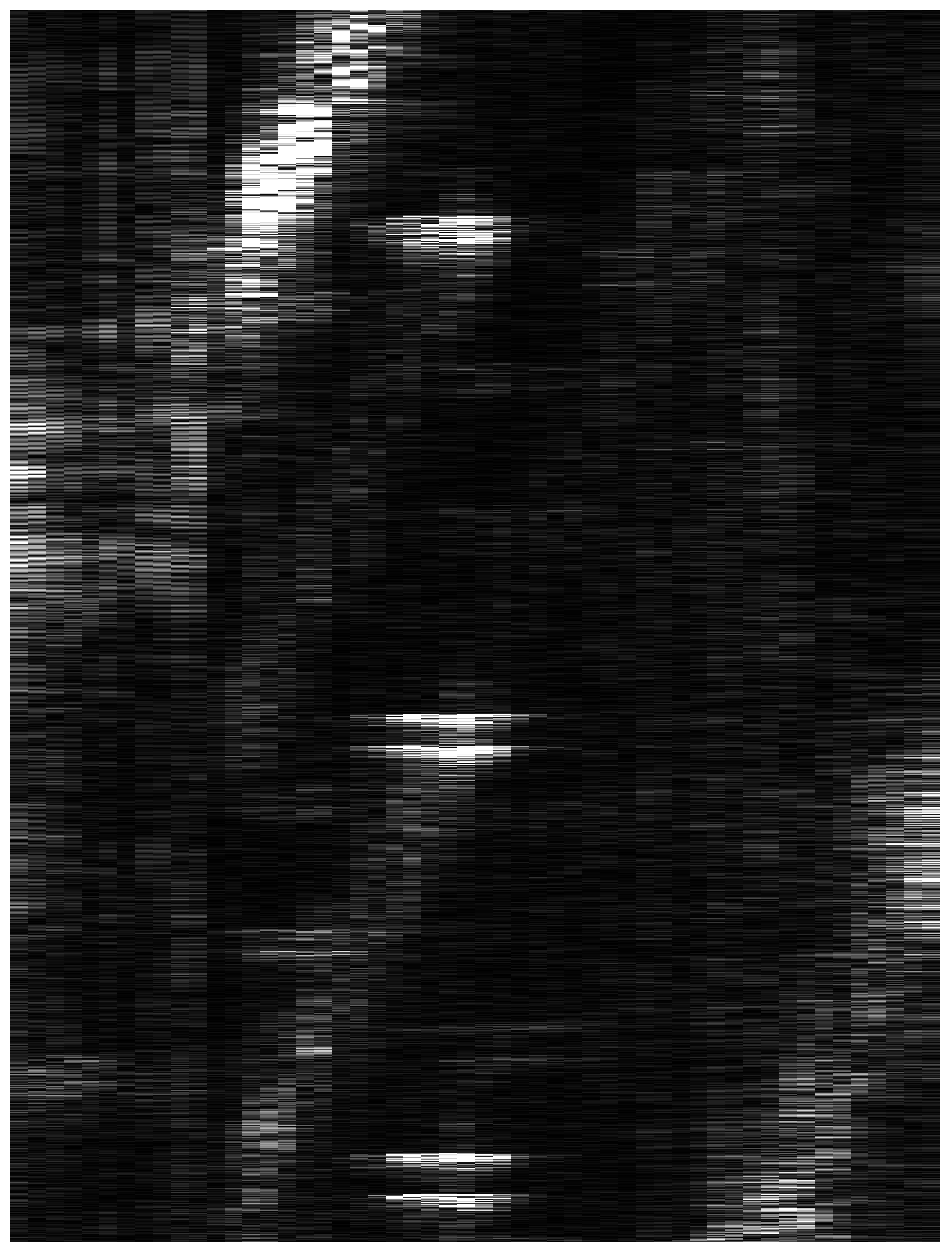

In [8]:
from visualisation import plot_timeframe
import numpy as np
from data import load_from_file, prepocess

import cv2

filename = "091932.npy"

data = load_from_file(filename)
# plot_timeframe(data)

img = data.to_numpy()

img = prepocess(img)
original_img = img.copy()

plot_numpy(img)


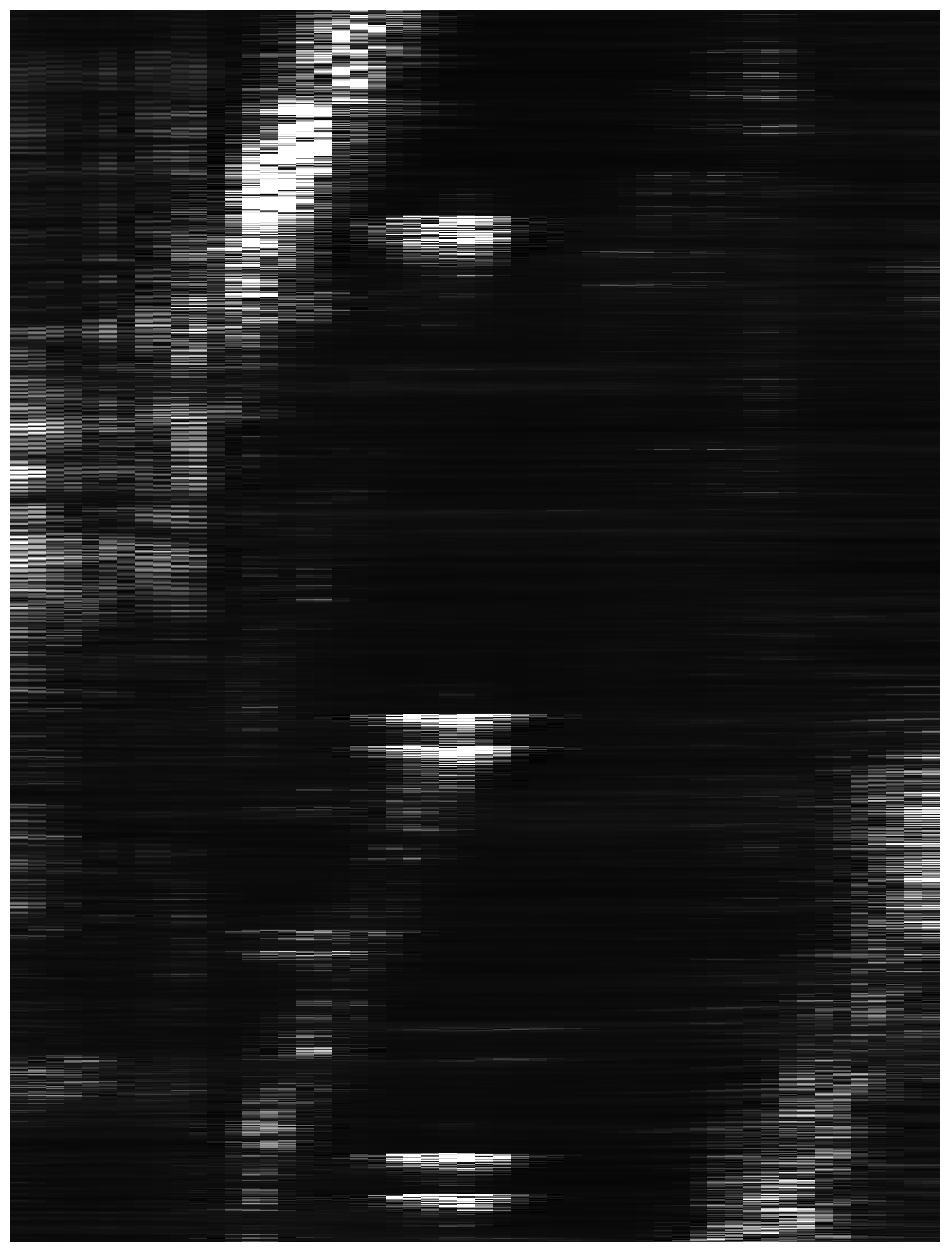

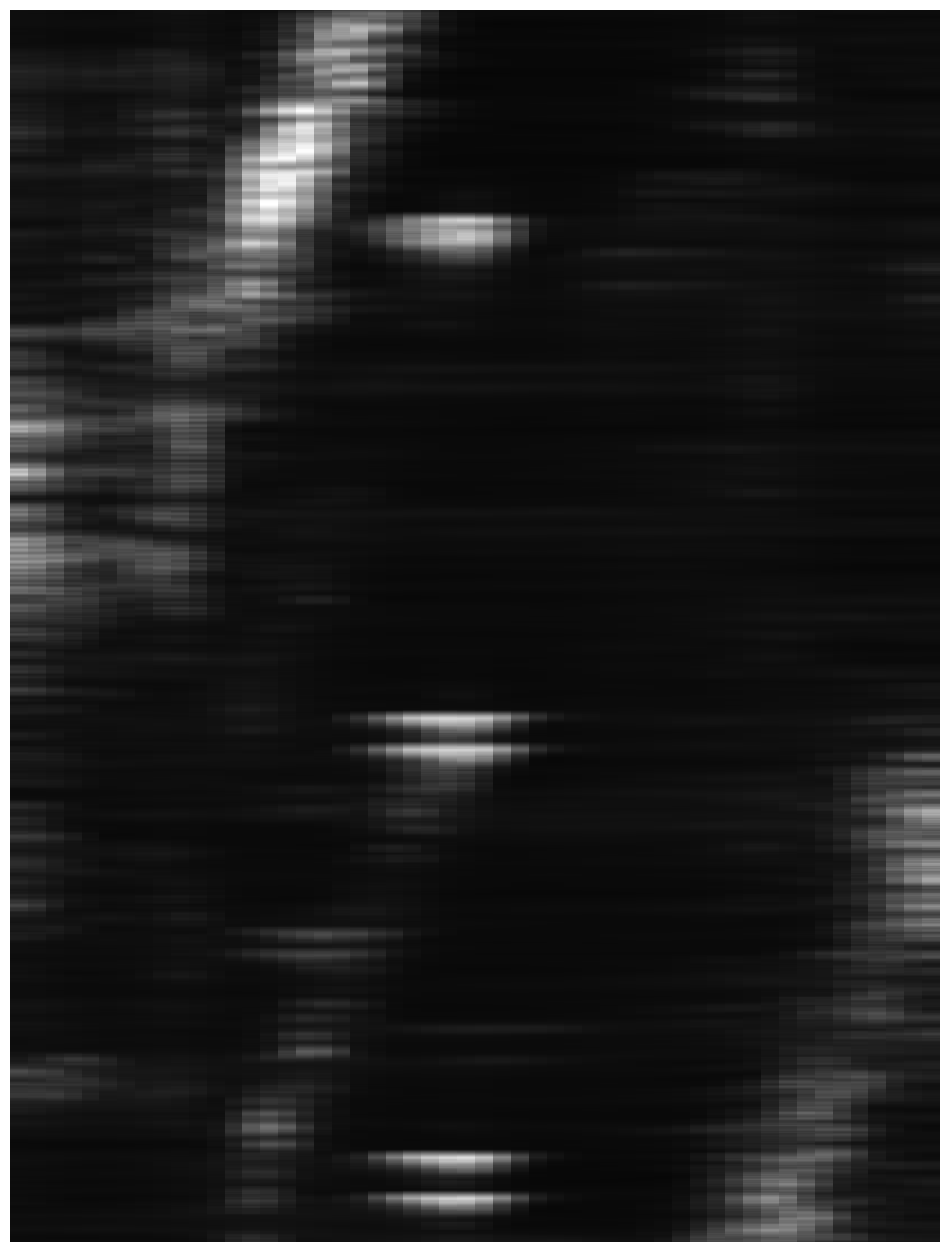

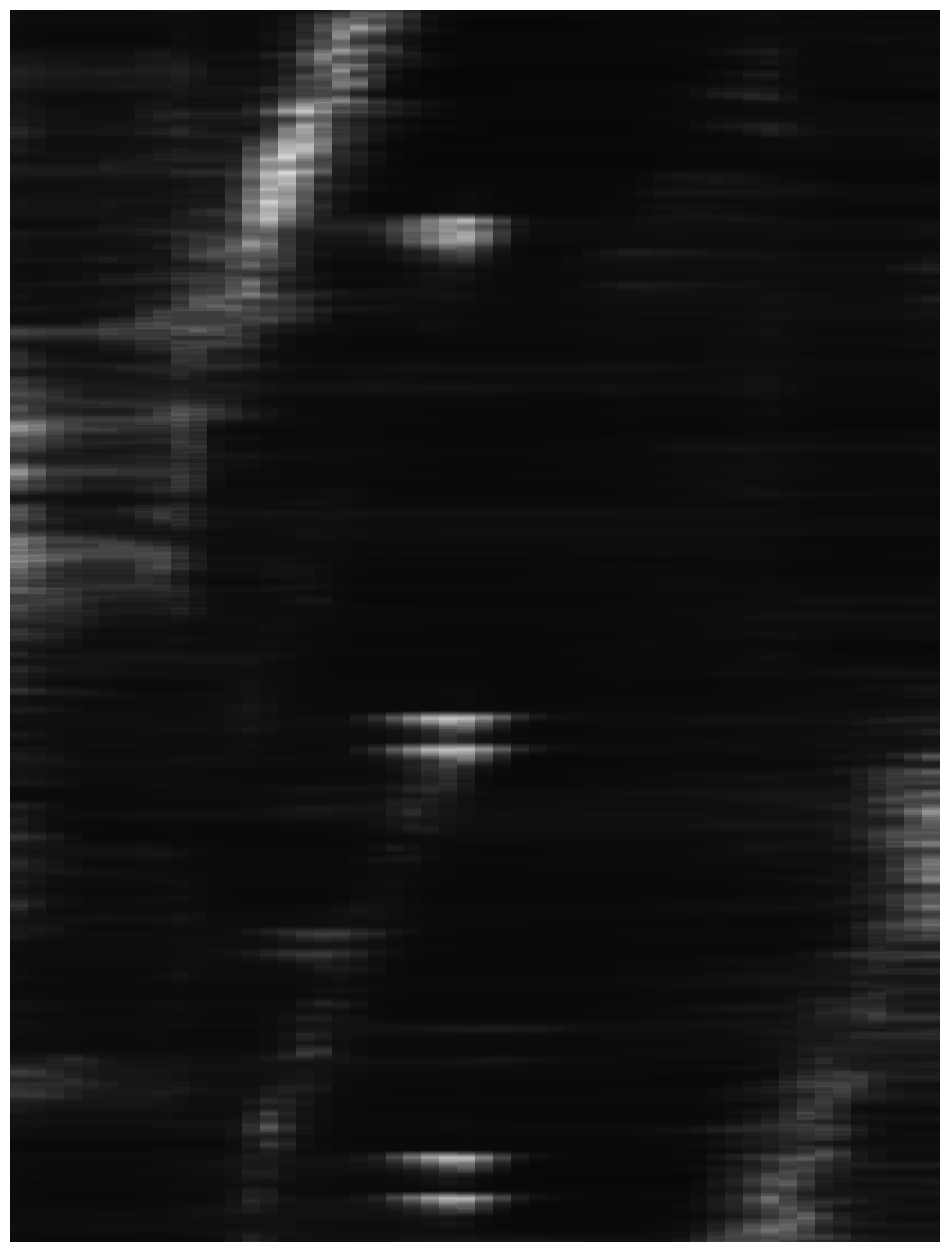

In [9]:

    # img = frequency_lowpass(img, 0.25)
    # if verbose:
    #     plot_numpy(img, title="Low-pass filtered image")

img = cv2.fastNlMeansDenoising(img, templateWindowSize=7, searchWindowSize=21, h=14)
    # if verbose:
    #     plot_numpy(img, title="Denoised image")
plot_numpy(img)

img = cv2.blur(img, (3, 41))
    # img = cv2.GaussianBlur(img, (3, 3), 0)
plot_numpy(img)


img = cv2.morphologyEx(
        img,
        cv2.MORPH_ERODE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (3, 9)),
        iterations=1,
    )
plot_numpy(img)

_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
   

    # img = cv2.morphologyEx(
    #     img,
    #     cv2.MORPH_OPEN,
    #     cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)),
    #     iterations=1,
    # )


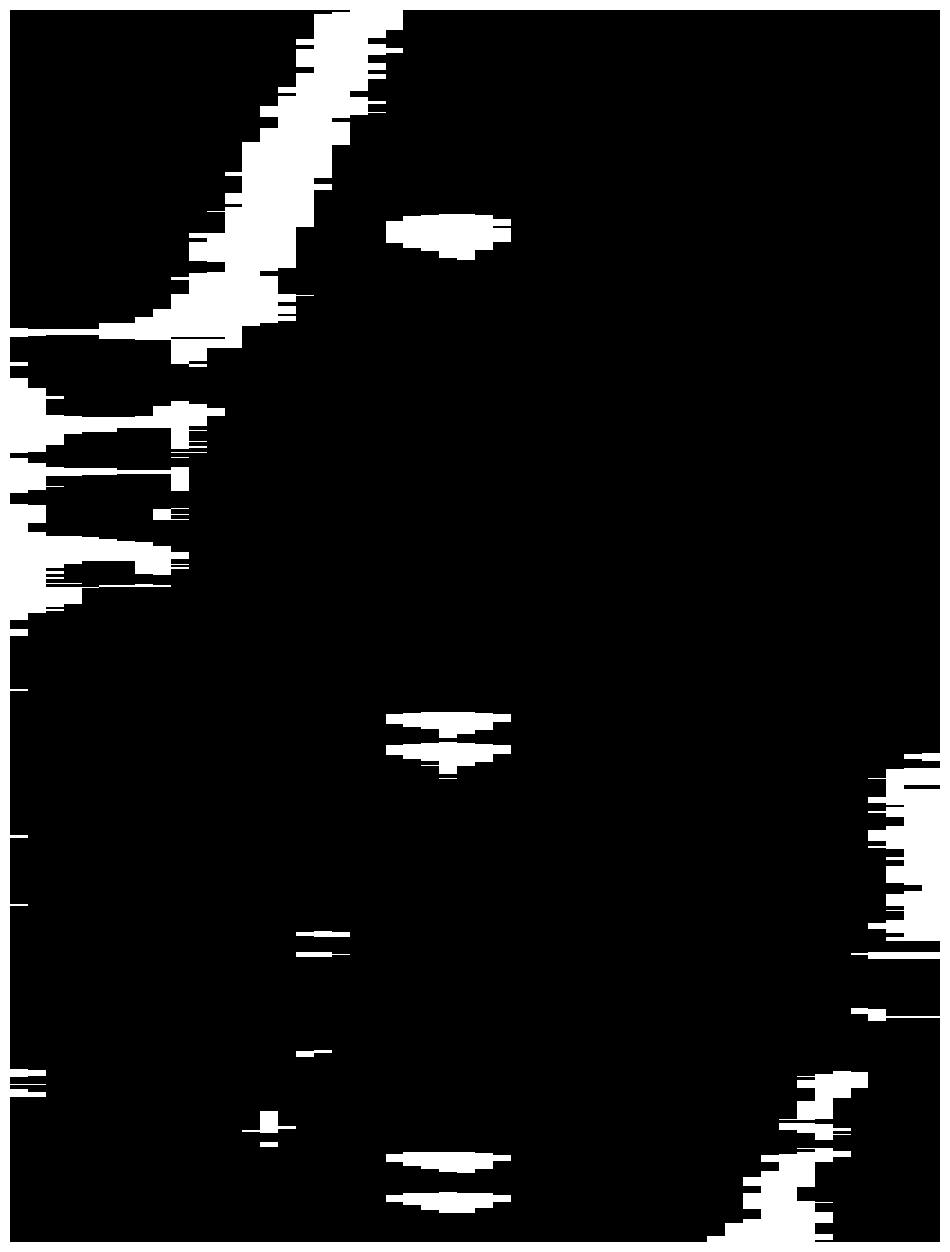

In [7]:
plot_numpy(img)

In [94]:
# img_i = pipeline_processing(img)

In [10]:
# plot_numpy(img_i)

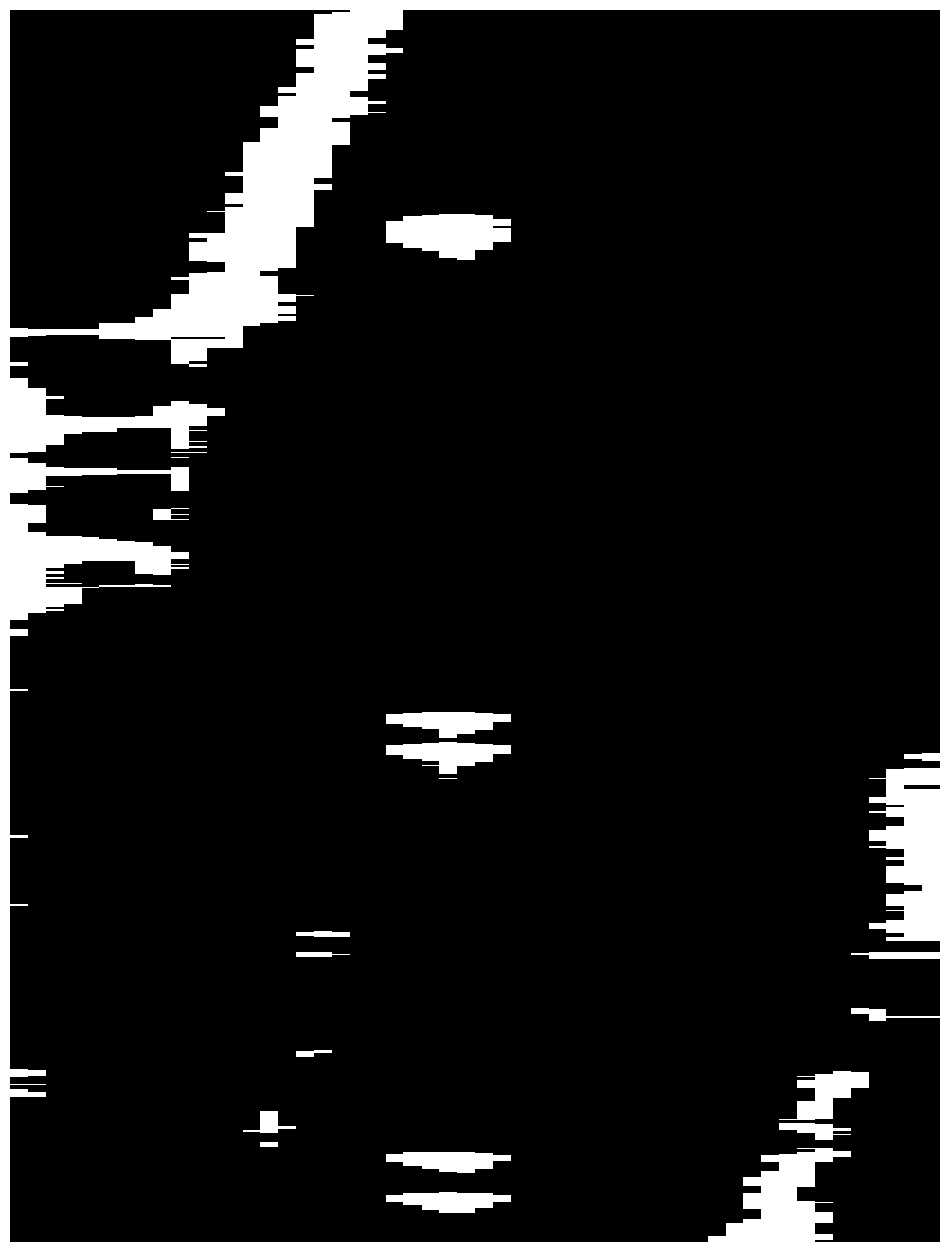

In [11]:
aspect_ratio = 12/16

h,w = img.shape

new_w = int(aspect_ratio * h)

img = cv2.resize(img, (new_w,h), interpolation=cv2.INTER_NEAREST)

plot_numpy(img)

In [52]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import MinMaxScaler

# X = np.nonzero(img_i)
# X = np.vstack(X).T

# X.shape
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# clustering = DBSCAN(eps=0.08, min_samples=300).fit(X_scaled)

# no_of_clusters = np.max(clustering.labels_)+1
# print(no_of_clusters)


2


In [13]:
no_of_clusters, X, clustering = clustering(img_i)

NameError: name 'img_i' is not defined

In [12]:
colors = generate_colors(no_of_clusters) 
img_clusters = cv2.cvtColor(img_i, cv2.COLOR_GRAY2RGB)

print("Number of clusters: ", no_of_clusters)
for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    # print(idx)
    # print(f"Cluster{cluster_id}: {np.sum(idx)} members")
    img_clusters[idx.T[0], idx.T[1],:] = colors[cluster_id]

plot_numpy(img_clusters, "091852", True)

NameError: name 'no_of_clusters' is not defined

In [14]:
from sklearn.linear_model import LinearRegression

lines = []

for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    x_coords = idx[:, 1].reshape(-1,1)
    y_coords = idx[:, 0]
    
    model = LinearRegression()
    model.fit(x_coords, y_coords)

    slope = model.coef_[0]
    intercept = model.intercept_

    x_start = np.min(x_coords)
    x_end = np.max(x_coords)
    # print(x_start)
    # y_start = model.predict([[x_start]])
    # y_end = model.predict([[x_end]])
    r2 = model.score(x_coords, y_coords)
    print(f"R2 of cluster {cluster_id}: {r2}")

    #DISCARDING R2 < 0.5
    # if r2 < 0.5:
    #     print(f"Discarded cluster {cluster_id} with R2={r2}")
    #     continue
    velocity = velocity_from_slope(slope)
    print(f"Detected velocity: {velocity} m/s ({ mps_to_kmph(velocity) } km/h)")
    print()
    lines.append((slope,intercept, x_start, x_end))
    

plot_numpy_with_lines(img, lines)


NameError: name 'no_of_clusters' is not defined

69.0

8

In [15]:
lines = cv2.HoughLinesP(
            img, # Input edge image
            1, # Distance resolution in pixels
            np.pi/250, # Angle resolution in radians
            threshold=500, # Min number of votes for valid line
            minLineLength=1500, # Min allowed length of line
            maxLineGap=400 # Max allowed gap between line for joining them
            )

651
(651, 1, 4)


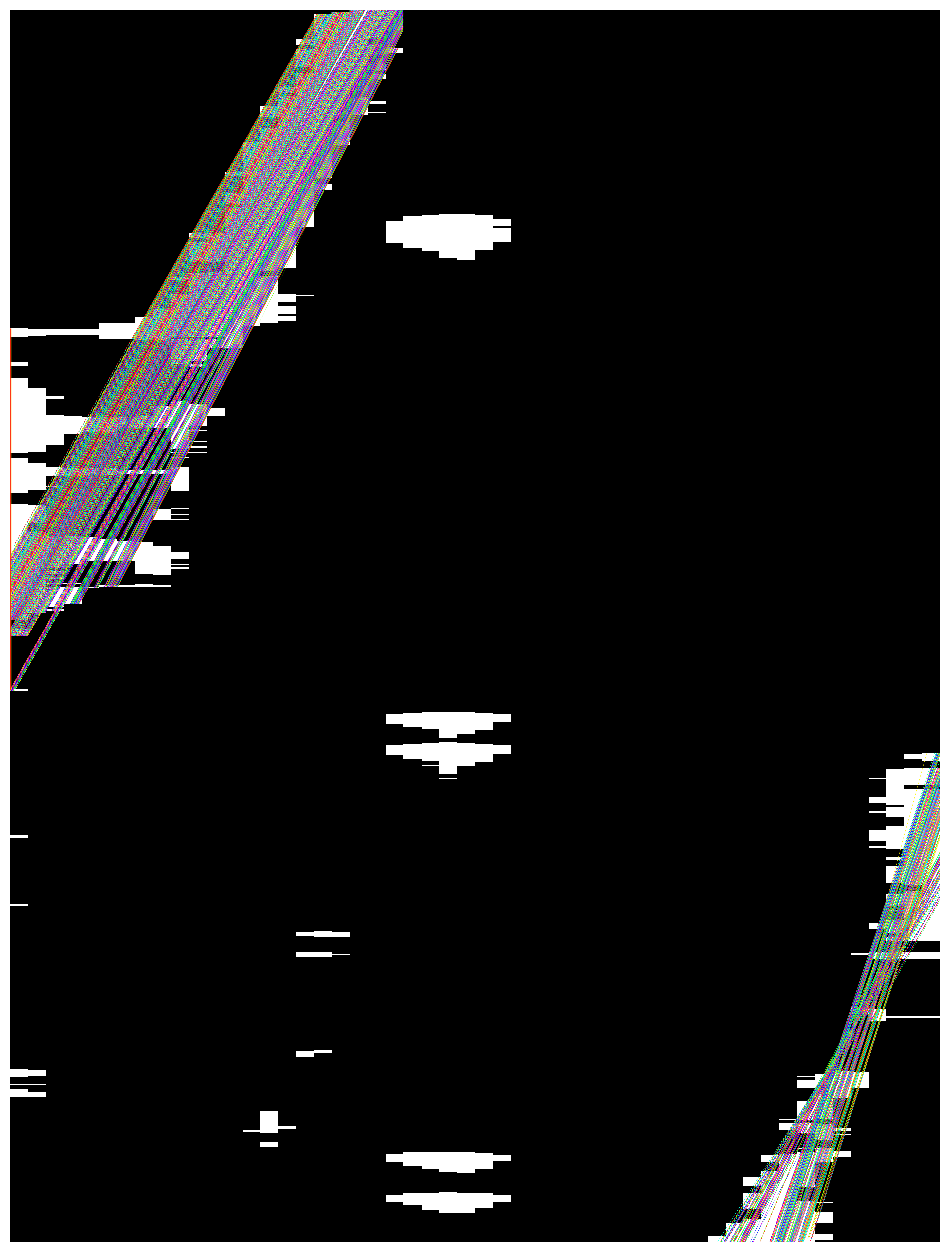

In [46]:
# lines = cv2.HoughLinesP(img_i, rho=1, theta=np.pi / 250, threshold=100, minLineLength = 100, maxLineGap=50)
lines_dst = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

if lines is not None:
    print(len(lines))
    colors = generate_colors(len(lines))
    for i in range(0, len(lines)):
            c = (255-i*10,i*10,0)
            c = tuple(colors[i].astype(int))
            
        
            l = lines[i][0]
            cv2.line(lines_dst, (l[0], l[1]), (l[2], l[3]), (int(c[0]), int(c[1]), int(c[2])), 1, cv2.LINE_AA)

lines_dst.shape
print(lines.shape)
plot_numpy(lines_dst)


In [50]:
def get_slope_and_intercept(x1, y1, x2, y2):
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope*x1
    return slope, intercept

def get_slope_and_intercept_np(arr):
    x1, y1, x2, y2 = arr
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope*x1
    return slope, intercept

get_slope_and_intercept_np(np.array([1,1,2,2]))

(1.0, 0.0)

In [73]:
valid_lines = lines[~(lines[:,:,0] == lines[:,:,2]), :]
lines_directional = np.apply_along_axis(get_slope_and_intercept_np, axis=1, arr=valid_lines)
lines_directional

array([[-1.71567568e+00,  3.20316649e+03],
       [-1.71575528e+00,  3.16900000e+03],
       [-1.71567568e+00,  3.27350919e+03],
       ...,
       [-3.08087092e+00,  1.86449611e+04],
       [-1.76482618e+00,  3.16080368e+03],
       [-1.71544058e+00,  3.26962975e+03]])

3


/home/krzys/anaconda3/envs/d2l/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/krzys/anaconda3/envs/d2l/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


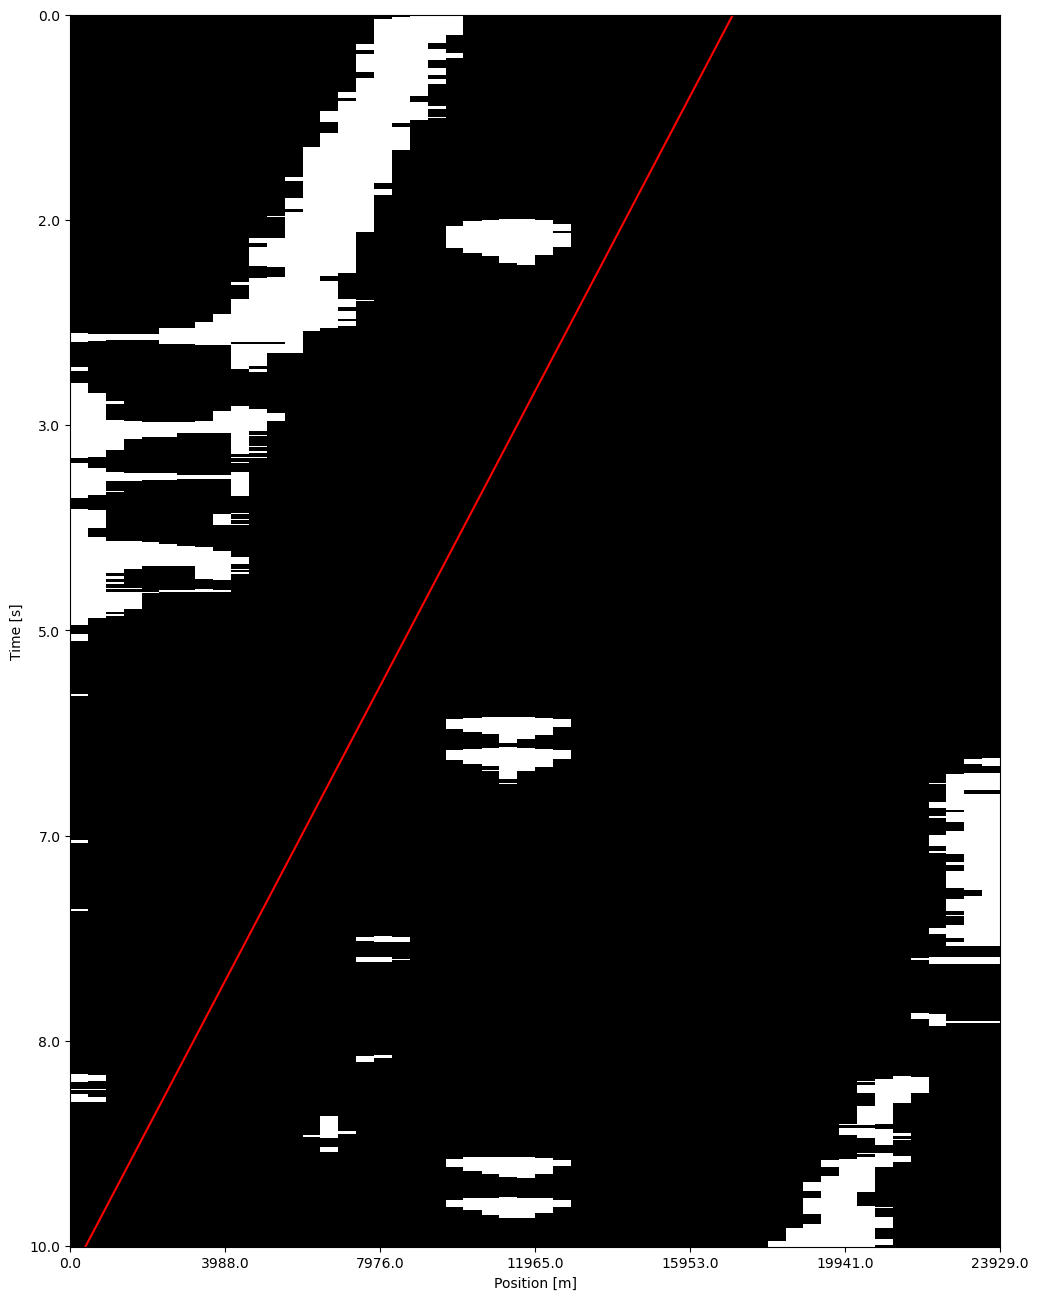

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(lines_directional)
clustering = DBSCAN(eps=0.2, min_samples=5).fit(X_scaled)

no_of_clusters = np.max(clustering.labels_) + 1
print(no_of_clusters)

average_lines = []
for cluster_id in range(no_of_clusters):
    average_line = np.mean(valid_lines[cluster.labels_ == cluster_id],axis=0)
    average_lines.append(average_line)
    
plot_numpy_with_lines(img, [(*get_slope_and_intercept(*l), 0, img.shape[1]) for l in average_lines])



In [83]:
# from sklearn.cluster import KMeans


# kmeans = KMeans(n_clusters=2, random_state=0xc0ffee).fit(lines_directional)

# kmeans.labels_
# l1 = np.mean(valid_lines[kmeans.labels_ == 0],axis=0)
# l2 = np.mean(valid_lines[kmeans.labels_ == 1],axis=0)
# # l3 = np.mean(lines[kmeans.labels_ == 2],axis=0)


In [121]:
# print(lines)
# average of points
# print(np.mean(lines, axis=0, dtype=float))
# x1, y1, x2, y2 = np.mean(lines, axis=0, dtype=int)[0]

# print(x1, y1, x2, y2)

TypeError: cannot unpack non-iterable numpy.int64 object

In [128]:
slope, intercept = get_slope_and_intercept(*l3)

In [100]:
slope = (y2-y1)/(x2-x1)
# slope = 0
intercept = y1 - slope*x1

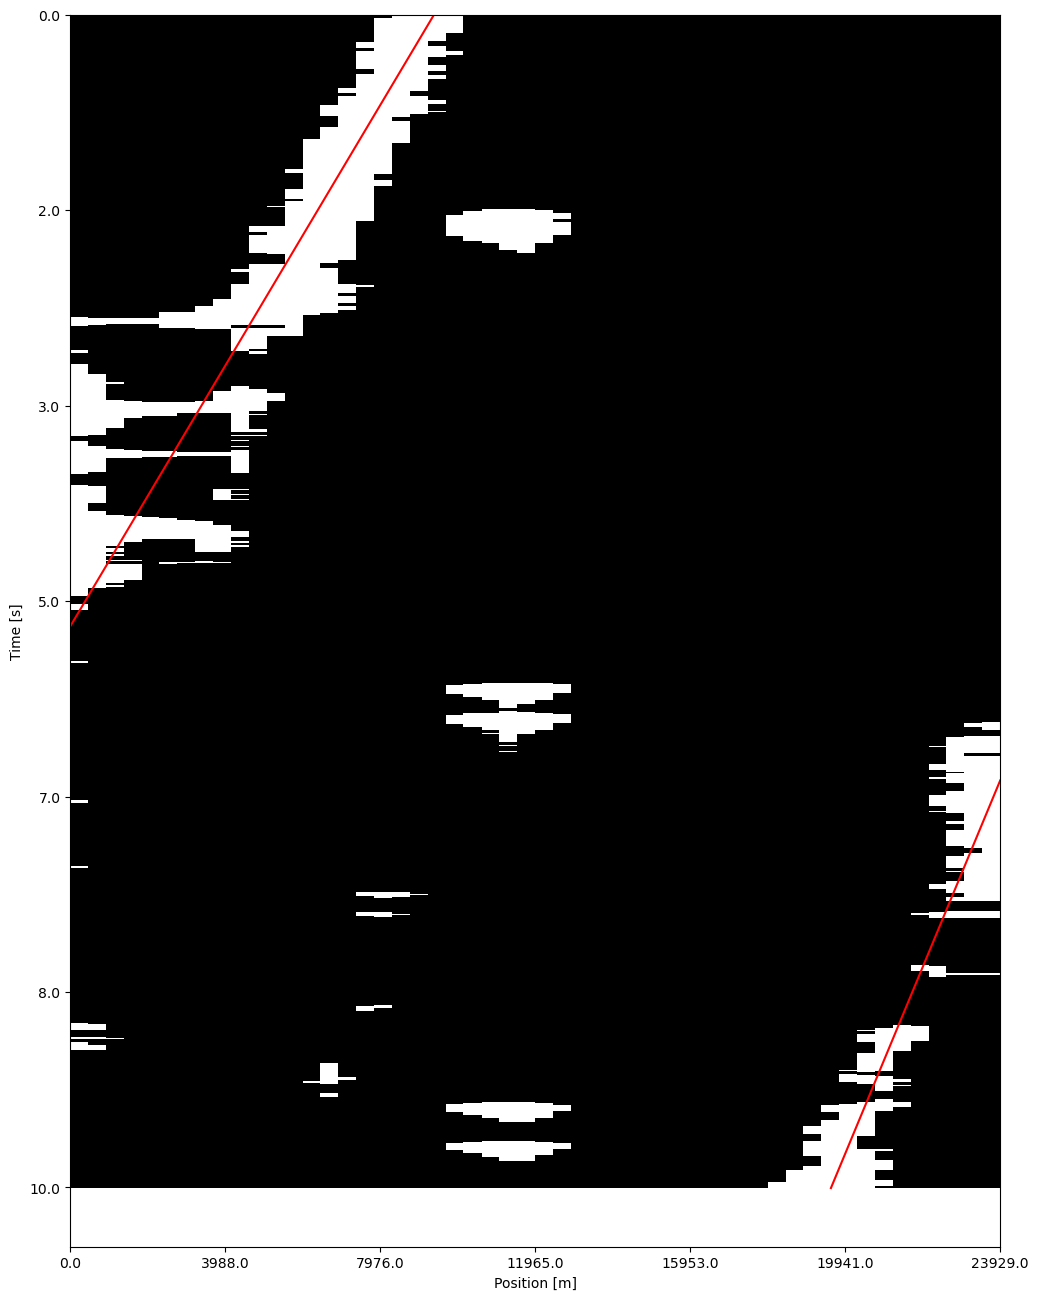

In [87]:
plot_numpy_with_lines(img, [(*get_slope_and_intercept(*l2), 0, img.shape[1]),(*get_slope_and_intercept(*l1), 0, img.shape[1])])

In [77]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask, (s[0] // 2, s[1] // 2), s[0] // div, 1, -1)


def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum


def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

def showFreqAndImages(frequencies, images):
    fig, axes = plt.subplots(2, len(frequencies), figsize=(20, 10))
    for i, (freq, img) in enumerate(zip(frequencies, images)):
        axes[0, i].imshow(freq, cmap="gray", vmin=0, vmax=255)
        axes[1, i].imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()

In [78]:
img_grayscale = img

laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
img_i = cv2.filter2D(img_grayscale, -1, laplacian)

m1 = get_mask(img_grayscale.shape, 2)
m2 = get_mask(img_grayscale.shape, 8)
m3 = get_mask(img_grayscale.shape, 32)

fshift, spectrum = fft(img_grayscale)

img_back_1 = ifft(fshift * m1)
img_back_2 = ifft(fshift * m2)
img_back_3 = ifft(fshift * m3)

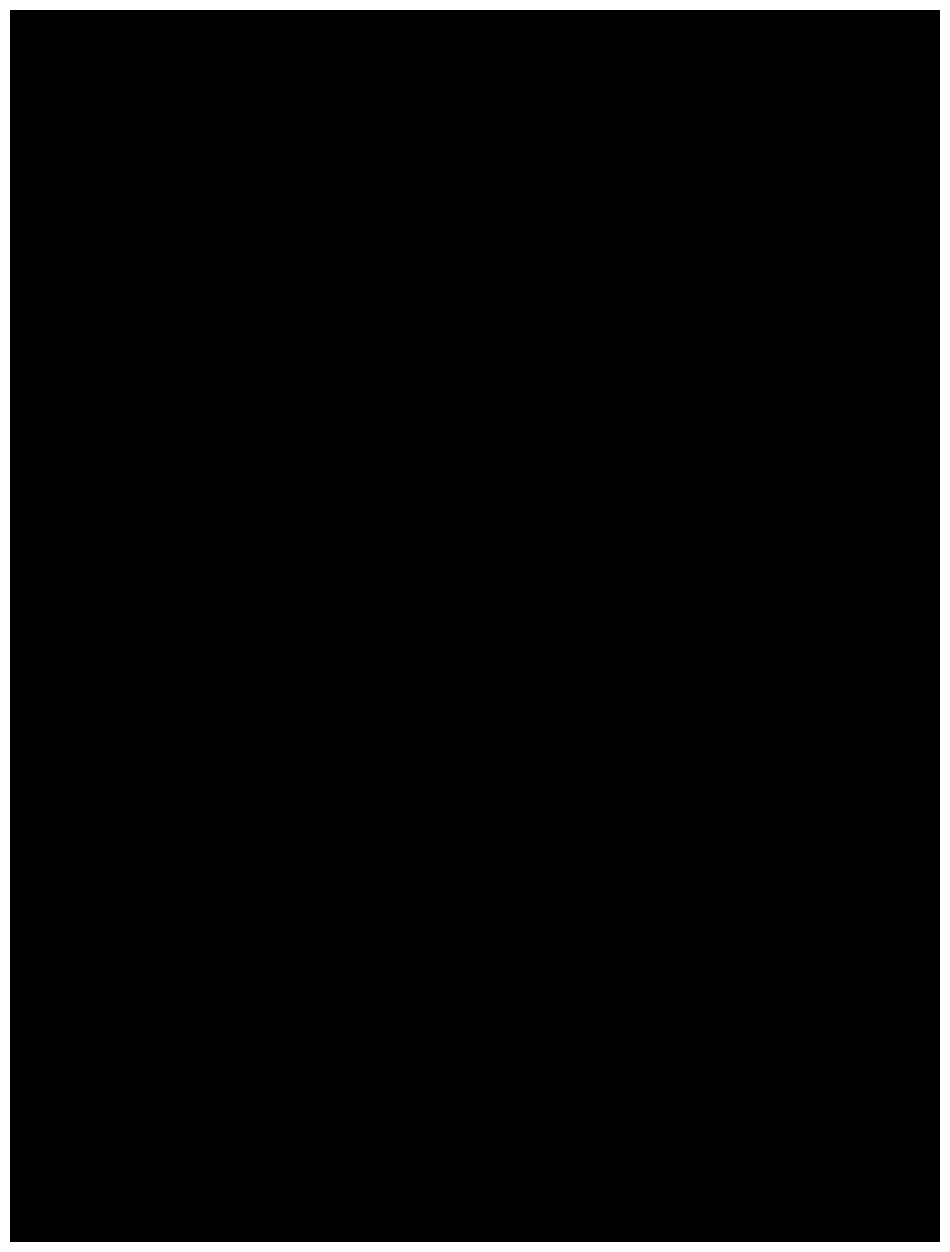

In [80]:
plot_numpy(img_back_3)

In [62]:
tr, img_i = cv2.threshold(img_i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [70]:
img_a = proper_opening(img_i)

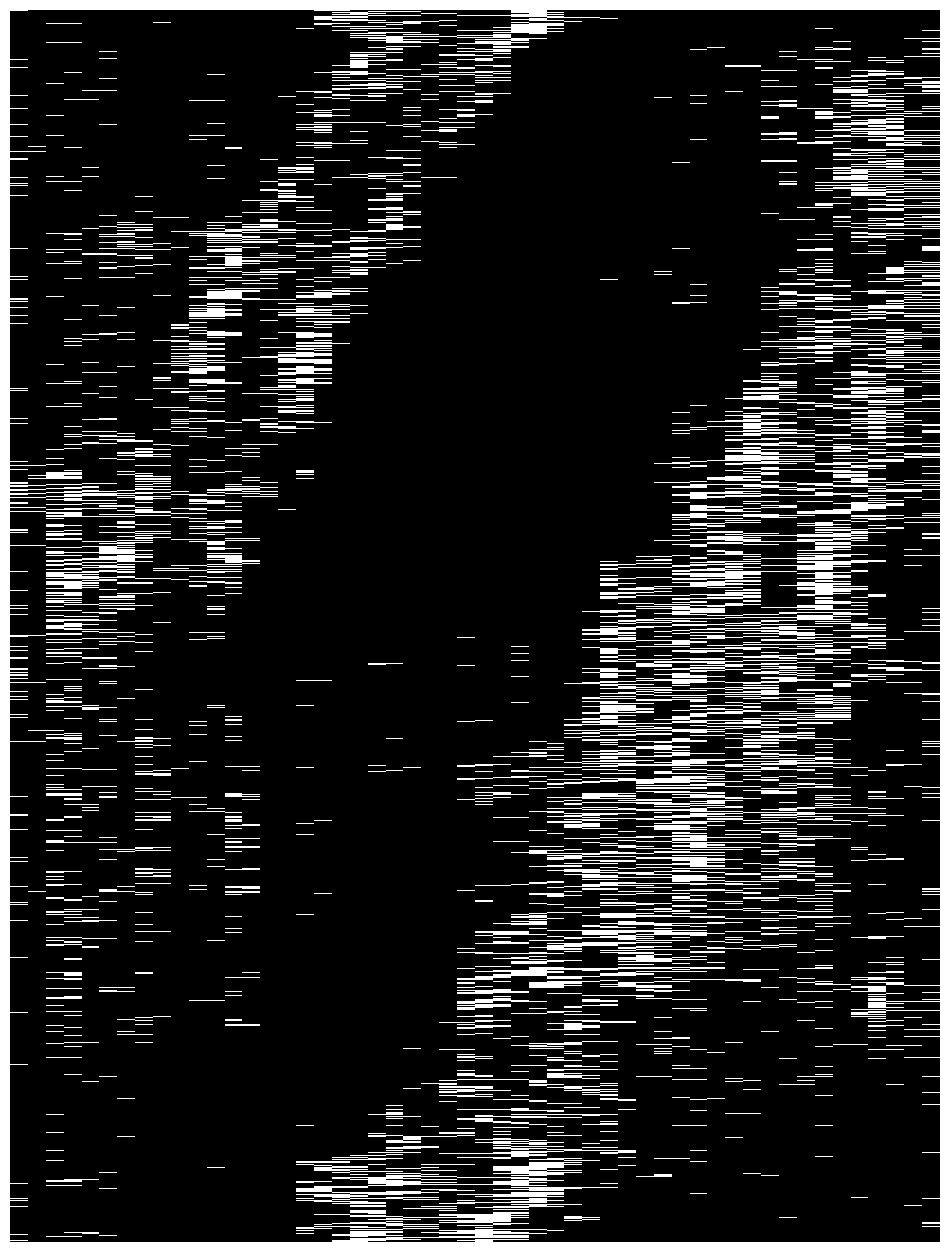

In [71]:
plot_numpy(img_i)